# Pair Trading of BABA US Equity and 9988 HK Equity

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from xbbg import blp
from datetime import datetime
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint


def run_pairs_strategy(ticker1, ticker2, start_date, end_date):
    # Clean up ticker names for column names
    def sanitize_ticker(ticker):
        return ticker.replace(' ', '_').replace('.', '').replace('&', 'and').replace('/', '_')

    ticker1_clean = sanitize_ticker(ticker1)
    ticker2_clean = sanitize_ticker(ticker2)

    # Retrieve data
    df1 = blp.bdh(ticker1, 'PX_LAST', start_date, end_date, FX='USD')
    df2 = blp.bdh(ticker2, 'PX_LAST', start_date, end_date, FX='USD')

    # Data processing
    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)
    df1.columns = ['Date', 'Adj Close']
    df2.columns = ['Date', 'Adj Close']

    df = pd.merge(df1, df2, on='Date', suffixes=('_' + ticker1_clean, '_' + ticker2_clean))
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    coint_t, pvalue, crit_value = coint(df['Adj Close_' + ticker1_clean], df['Adj Close_' + ticker2_clean])
    print( coint_t, pvalue, crit_value)

    trainset = np.arange(0, 350)
    testset = np.arange(trainset.shape[0], df.shape[0])

    # Build OLS model
    model = sm.OLS(df['Adj Close_' + ticker1_clean].iloc[trainset],
                   df['Adj Close_' + ticker2_clean].iloc[trainset])
    results = model.fit()
    hedgeRatio = results.params

    # Compute spread
    spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
    spreadMean = np.mean(spread.iloc[trainset])
    spreadStd = np.std(spread.iloc[trainset])

    df['zscore'] = (spread - spreadMean) / spreadStd

    # Positions
    df['positions_' + ticker1_clean + '_Long'] = 0
    df['positions_' + ticker2_clean + '_Long'] = 0
    df['positions_' + ticker1_clean + '_Short'] = 0
    df['positions_' + ticker2_clean + '_Short'] = 0

    df.loc[df.zscore >= 2, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = [-1, 1]  # Short spread
    df.loc[df.zscore <= -2, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = [1, -1]  # Buy spread
    df.loc[df.zscore <= 0, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = 0  # Exit short spread
    df.loc[df.zscore >= 0, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = 0  # Exit long spread

    df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal

    # Calculate positions and PnL
    positions_Long = df[['positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long']]
    positions_Short = df[['positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short']]
    positions = positions_Long.values + positions_Short.values
    positions = pd.DataFrame(positions, columns=[ticker1_clean, ticker2_clean], index=df.index)
    dailyret = df[['Adj Close_' + ticker1_clean, 'Adj Close_' + ticker2_clean]].pct_change()

    pnl = (positions.shift() * dailyret.values).sum(axis=1)
    pnl = pnl - abs(positions - positions.shift()).sum(axis=1) * 0.005 # pnl - cost of transactions at 0.005
    sharpeTrainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]])
    sharpeTestset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])

    # Plot spread and cumulative PnL
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.title(f"Spread for {ticker1} and {ticker2}")
    plt.plot(spread.iloc[trainset], label='Train Spread')
    plt.plot(spread.iloc[testset], label='Test Spread')
    plt.legend()

    plt.subplot(212)
    plt.title(f"Cumulative PnL for {ticker1} and {ticker2}")
    plt.plot(np.cumsum(pnl[testset]), label='Test PnL')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save positions
    positions.to_pickle(f'positions_{ticker1_clean}_{ticker2_clean}.pkl')

    # Return outputs
    return {
        'sharpeTrainset': sharpeTrainset,
        'sharpeTestset': sharpeTestset,
        'positions': positions,
        'pnl': pnl,
        'df': df
    }

# Define your list of pairs
pairs_list = [
    # Hong Kong/China
    ('BABA US Equity', '9988 HK Equity'),  # Alibaba Group Holding Ltd.
    ('TCEHY US Equity', '700 HK Equity'),  # Tencent Holdings Ltd.
    ('MNSO US Equity', '9896 HK Equity'),  # MINISO Group Holding Ltd.
    ('JD US Equity', '9618 HK Equity'),    # JD.com Inc.
    ('PNGAY US Equity', '2318 HK Equity'), # Ping An Insurance (Group) Co. of China Ltd.
    ('BIDU US Equity', '9888 HK Equity'),  # Baidu Inc.
    ('NTES US Equity', '9999 HK Equity'),  # NetEase Inc.
    ('XIACY US Equity', '1810 HK Equity'), # Xiaomi Corp.
    ('MPNGY US Equity', '3690 HK Equity'), # Meituan Dianping
    ('LI US Equity', '2015 HK Equity'),    # Li Auto Inc.
    ('XPEV US Equity', '9868 HK Equity'),  # XPeng Inc.
    ('TCOM US Equity', '9961 HK Equity'),  # Trip.com Group Ltd.
    ('YUMC US Equity', '9987 HK Equity'),  # Yum China Holdings Inc.
]

start_date = '2023-01-01'  # Adjust the start date as needed
end_date = datetime.today().strftime('%Y-%m-%d')  # Today's date in 'YYYY-MM-DD' format

# Loop over each pair and run the strategy
for ticker1, ticker2 in pairs_list:
    print(f"Processing pair: {ticker1}, {ticker2}")
    results = run_pairs_strategy(ticker1, ticker2, start_date, end_date)
    print(f"Sharpe Ratio (Train): {results['sharpeTrainset']}")
    print(f"Sharpe Ratio (Test): {results['sharpeTestset']}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from xbbg import blp
from datetime import datetime
from statsmodels.tsa.stattools import coint

def run_pairs_strategy(ticker1, ticker2, start_date, end_date):
    # Clean up ticker names for column names
    def sanitize_ticker(ticker):
        return ticker.replace(' ', '_').replace('.', '').replace('&', 'and').replace('/', '_')

    ticker1_clean = sanitize_ticker(ticker1)
    ticker2_clean = sanitize_ticker(ticker2)

    # Retrieve data
    df1 = blp.bdh(ticker1, 'PX_LAST', start_date, end_date, FX='USD')
    df2 = blp.bdh(ticker2, 'PX_LAST', start_date, end_date, FX='USD')

    # Data processing
    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)
    df1.columns = ['Date', 'Adj_Close']
    df2.columns = ['Date', 'Adj_Close']

    df = pd.merge(df1, df2, on='Date', suffixes=('_' + ticker1_clean, '_' + ticker2_clean))
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    
    # Ensure there is enough data
    if df.shape[0] < 350:
        print(f"Not enough data for {ticker1} and {ticker2}")
        return None

    coint_t, pvalue, crit_value = coint(df['Adj_Close_' + ticker1_clean], df['Adj_Close_' + ticker2_clean])
    print(f"Cointegration test for {ticker1} and {ticker2}: t-statistic = {coint_t:.4f}, p-value = {pvalue:.4f}")

    trainset = np.arange(0, 350)
    testset = np.arange(trainset.shape[0], df.shape[0])

    # Build OLS model
    model = sm.OLS(df['Adj_Close_' + ticker1_clean].iloc[trainset],
                   df['Adj_Close_' + ticker2_clean].iloc[trainset])
    results = model.fit()
    hedgeRatio = results.params

    # Compute spread
    spread = df['Adj_Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj_Close_' + ticker2_clean]
    spreadMean = np.mean(spread.iloc[trainset])
    spreadStd = np.std(spread.iloc[trainset])

    df['zscore'] = (spread - spreadMean) / spreadStd

    # Positions
    df['positions_' + ticker1_clean + '_Long'] = 0
    df['positions_' + ticker2_clean + '_Long'] = 0
    df['positions_' + ticker1_clean + '_Short'] = 0
    df['positions_' + ticker2_clean + '_Short'] = 0

    df.loc[df.zscore >= 2.5, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = [-1, 1]  # Short spread
    df.loc[df.zscore <= -2.5, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = [1, -1]  # Buy spread
    df.loc[df.zscore <= 0, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = 0  # Exit short spread
    df.loc[df.zscore >= 0, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = 0  # Exit long spread

    df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal

    # Calculate positions and PnL
    positions_Long = df[['positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long']]
    positions_Short = df[['positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short']]
    positions = positions_Long.values + positions_Short.values
    positions = pd.DataFrame(positions, columns=[ticker1_clean, ticker2_clean], index=df.index)
    dailyret = df[['Adj_Close_' + ticker1_clean, 'Adj_Close_' + ticker2_clean]].pct_change()

    pnl = (positions.shift() * dailyret.values).sum(axis=1)
    pnl = pnl - abs(positions - positions.shift()).sum(axis=1) * 0.005  # pnl - cost of transactions at 0.005

    sharpeTrainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]])
    sharpeTestset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])

    # Save positions and pnl
    df['pnl'] = pnl
    df['positions'] = positions.sum(axis=1)  # Sum positions for net exposure

    # Return outputs
    return {
        'sharpeTrainset': sharpeTrainset,
        'sharpeTestset': sharpeTestset,
        'positions': positions,
        'pnl': pnl,
        'df': df
    }

# Define your list of pairs
pairs_list = [
    # Hong Kong/China
    ('BABA US Equity', '9988 HK Equity'),  # Alibaba Group Holding Ltd.
    ('TCEHY US Equity', '700 HK Equity'),  # Tencent Holdings Ltd.
    ('MNSO US Equity', '9896 HK Equity'),  # MINISO Group Holding Ltd.
    ('JD US Equity', '9618 HK Equity'),    # JD.com Inc.
    ('PNGAY US Equity', '2318 HK Equity'), # Ping An Insurance Co.
    ('BIDU US Equity', '9888 HK Equity'),  # Baidu Inc.
    ('NTES US Equity', '9999 HK Equity'),  # NetEase Inc.
    ('XIACY US Equity', '1810 HK Equity'), # Xiaomi Corp.
    ('MPNGY US Equity', '3690 HK Equity'), # Meituan Dianping
    ('LI US Equity', '2015 HK Equity'),    # Li Auto Inc.
    ('XPEV US Equity', '9868 HK Equity'),  # XPeng Inc.
    ('TCOM US Equity', '9961 HK Equity'),  # Trip.com Group Ltd.
    ('YUMC US Equity', '9987 HK Equity'),  # Yum China Holdings Inc.
]

start_date = '2022-01-01'  # Adjust the start date as needed
end_date = datetime.today().strftime('%Y-%m-%d')  # Today's date in 'YYYY-MM-DD' format

# Initialize a DataFrame to collect individual PnLs
combined_pnl = pd.DataFrame()

# Loop over each pair and run the strategy
for ticker1, ticker2 in pairs_list:
    print(f"\nProcessing pair: {ticker1}, {ticker2}")
    results = run_pairs_strategy(ticker1, ticker2, start_date, end_date)
    if results is not None:
        # Align pnl series by date index
        pnl_series = pd.Series(results['pnl'], index=results['df'].index, name=f"{ticker1} vs {ticker2}")
        combined_pnl = pd.concat([combined_pnl, pnl_series], axis=1)

# Sum the PnL across all pairs to get the total PnL
total_pnl = combined_pnl.sum(axis=1)

# Calculate cumulative PnL
cumulative_total_pnl = total_pnl.cumsum()

# Compute performance metrics
total_return = cumulative_total_pnl.iloc[-1]
num_days = cumulative_total_pnl.shape[0]
annual_factor = 252 / num_days
annualized_return = total_return * annual_factor
annualized_volatility = total_pnl.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Maximum Drawdown
cumulative_max = cumulative_total_pnl.cummax()
drawdown = cumulative_total_pnl - cumulative_max
max_drawdown = drawdown.min()

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cumulative_total_pnl, label='Total Cumulative PnL')
plt.title('Statistical Arbitrage Strategy: Cumulative PnL Across All Pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

# Print performance metrics
print("\nPerformance Metrics for the Combined Strategy:")
print(f"Total Return: {total_return:.2f}")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

Processing pair: BABA US Equity, 9988 HK Equity
-19.14923619084638 0.0 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

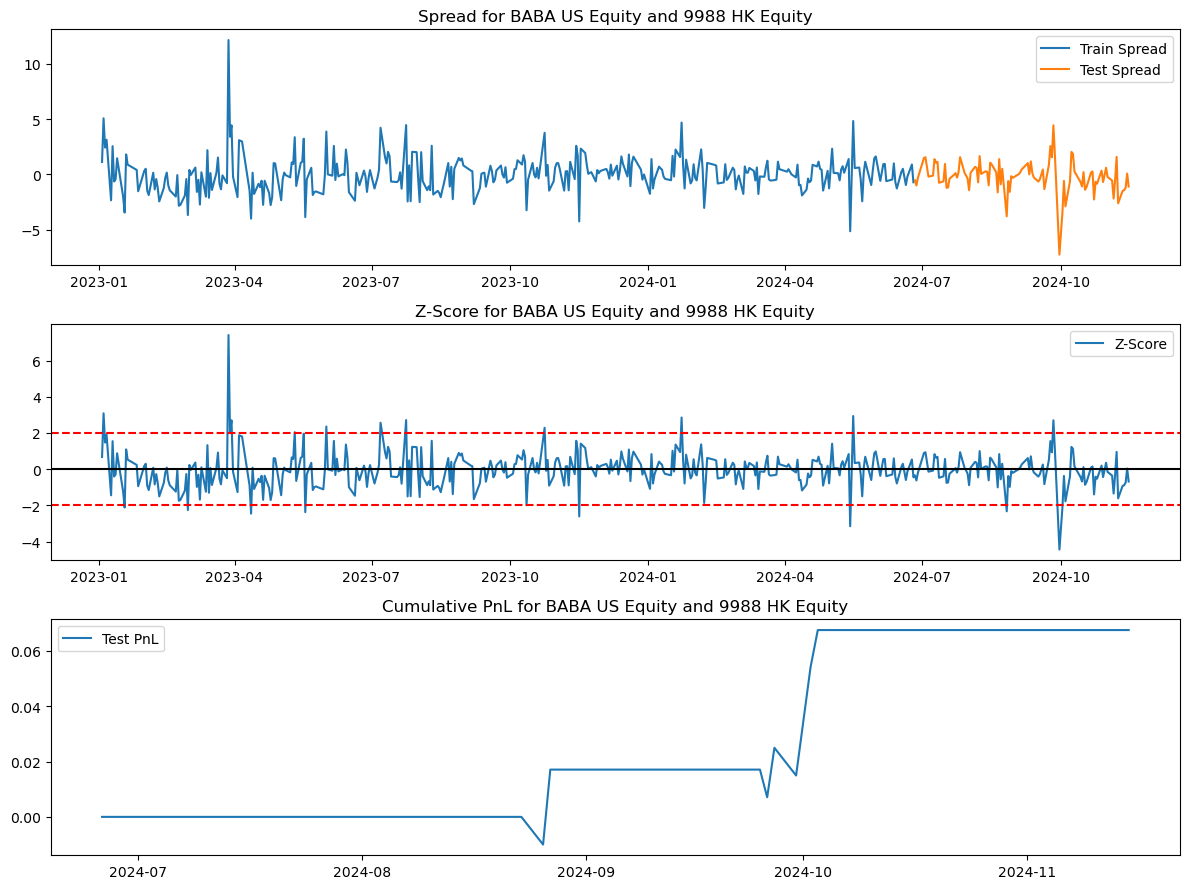

Sharpe Ratio (Train): 2.4207097682393233
Sharpe Ratio (Test): 1.990495920197584
Processing pair: TCEHY US Equity, 700 HK Equity
-6.685193672333646 4.718154503490918e-08 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

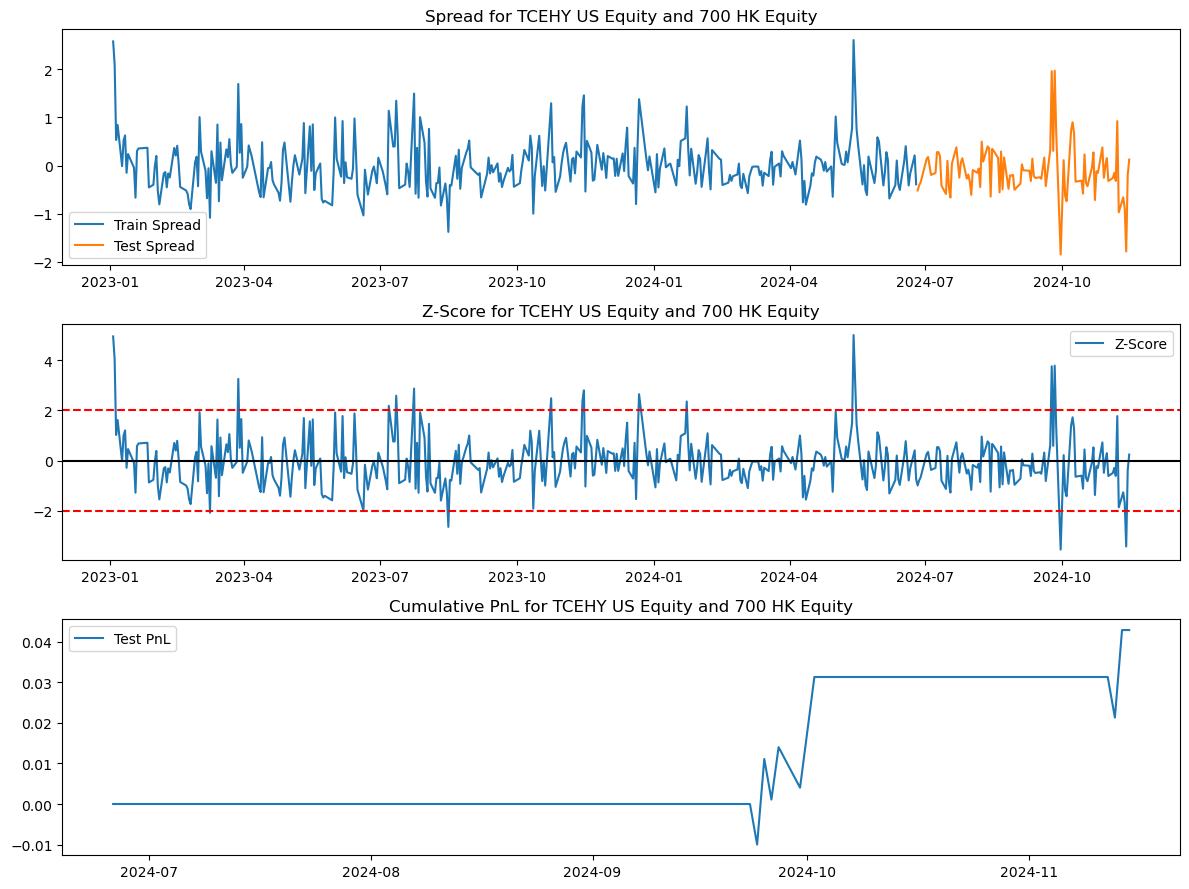

Sharpe Ratio (Train): 1.556527625082144
Sharpe Ratio (Test): 1.4806291012578239
Processing pair: MNSO US Equity, 9896 HK Equity
-21.933956488362558 0.0 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

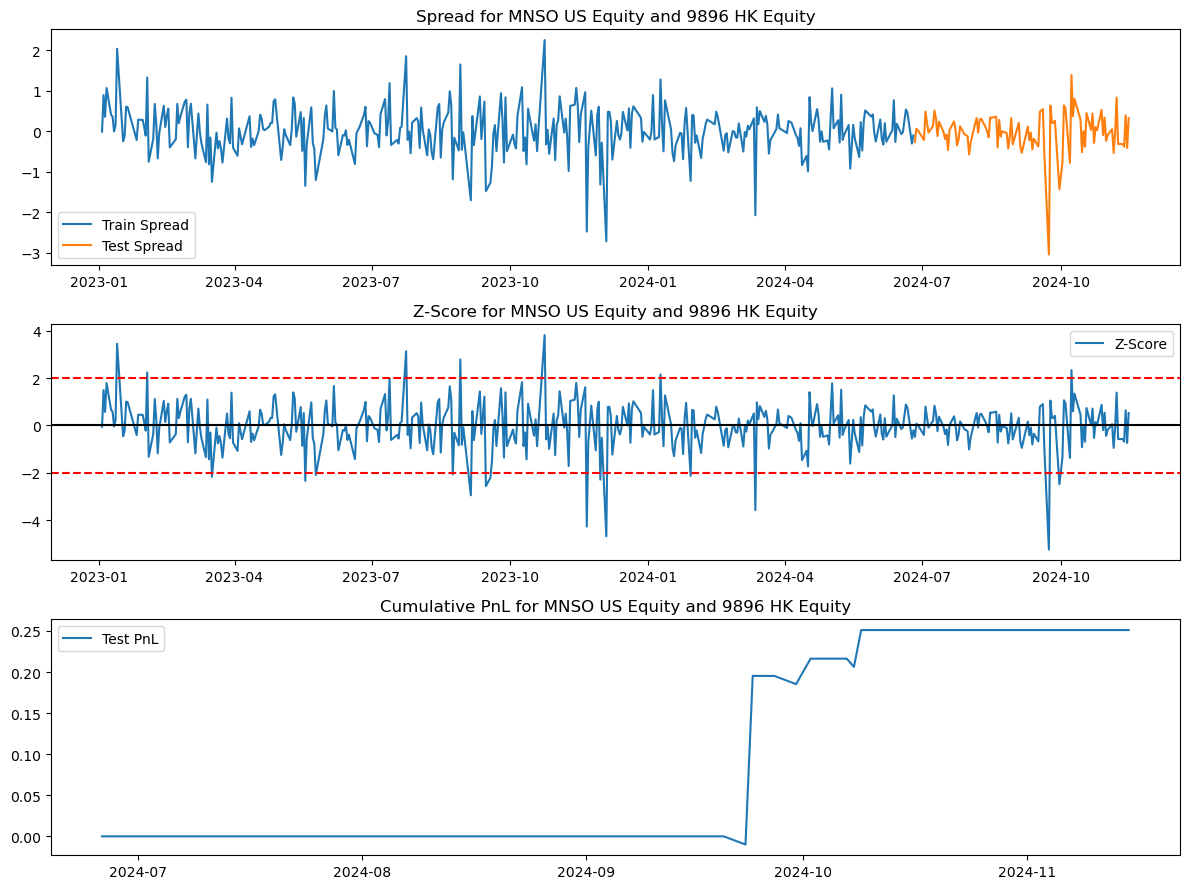

Sharpe Ratio (Train): 2.7974309204330865
Sharpe Ratio (Test): 1.9231152867145482
Processing pair: JD US Equity, 9618 HK Equity
-10.828225517706205 2.1752135705916897e-18 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

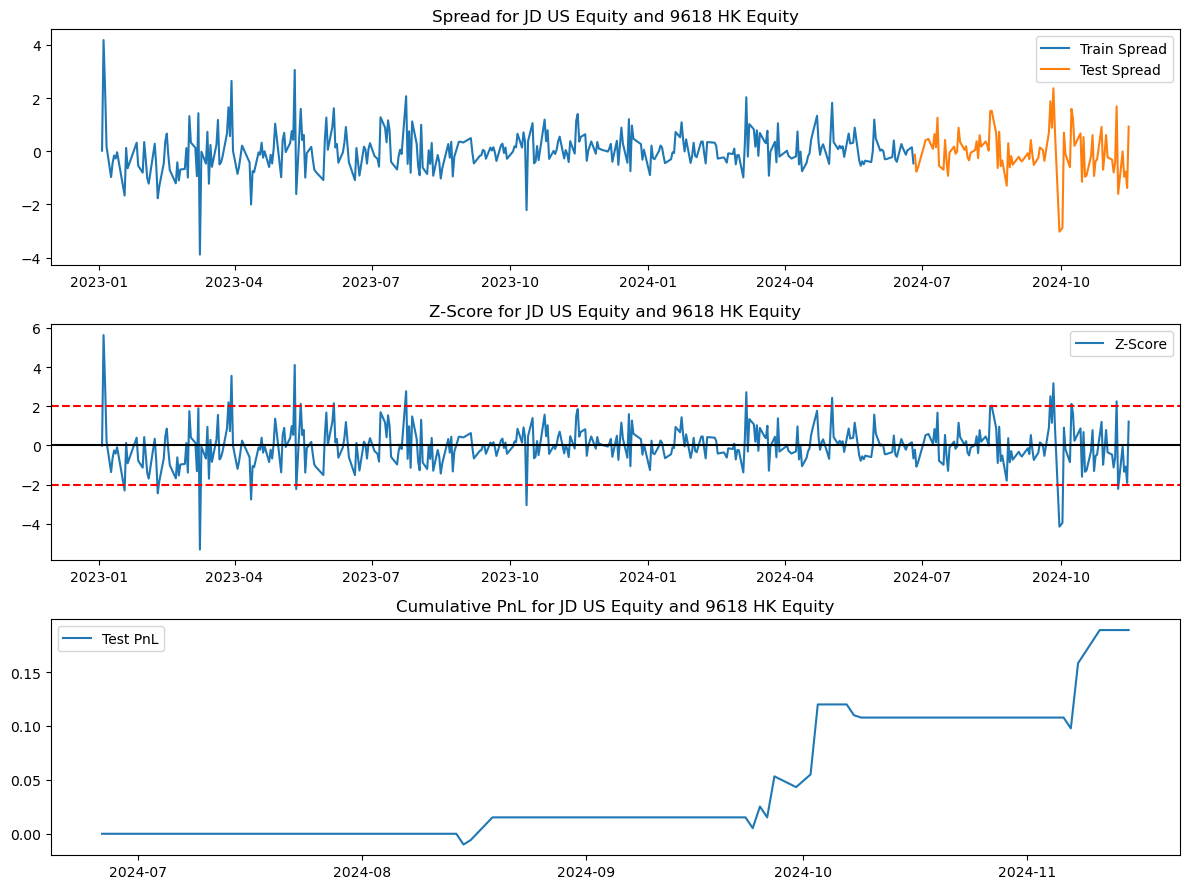

Sharpe Ratio (Train): 2.353266844254443
Sharpe Ratio (Test): 2.855680484680483
Processing pair: PNGAY US Equity, 2318 HK Equity
-5.895732085803354 2.715923231820925e-06 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

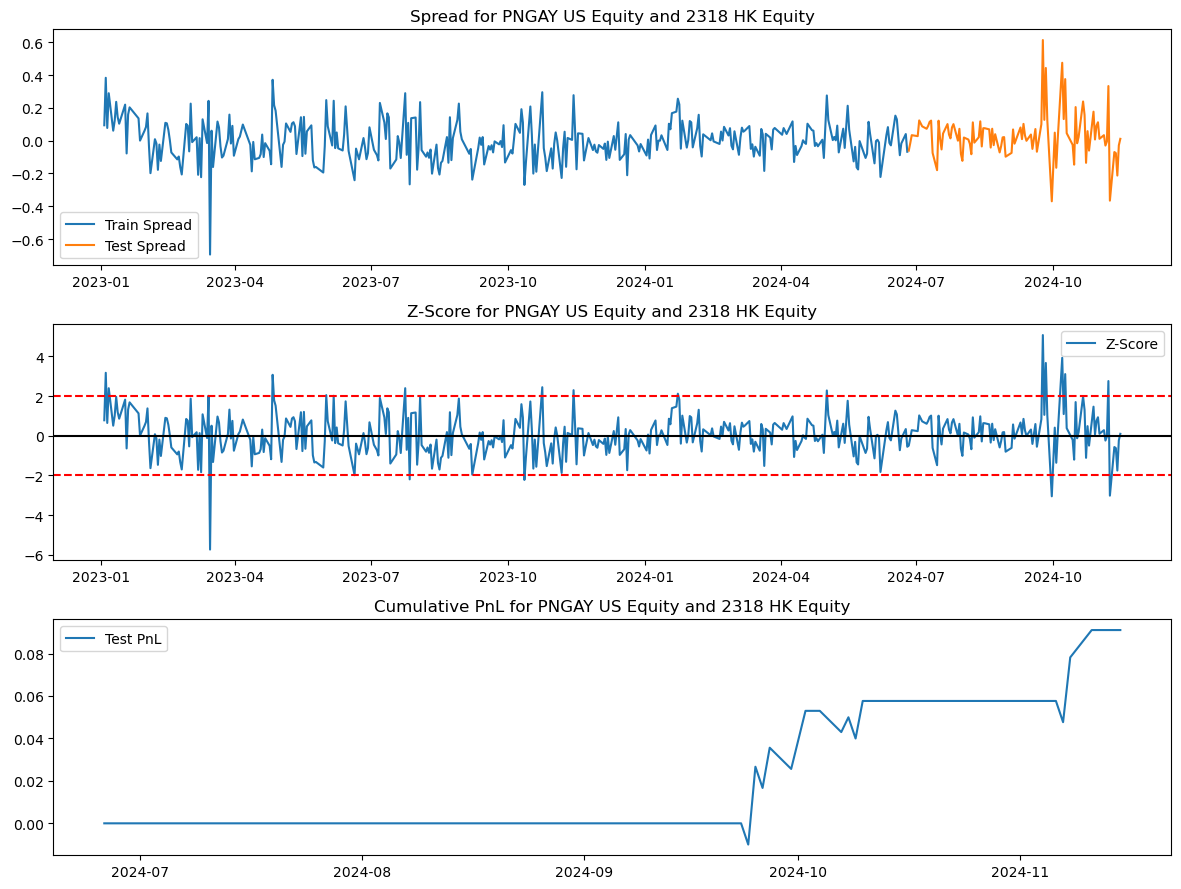

Sharpe Ratio (Train): 1.0471626640722869
Sharpe Ratio (Test): 2.2175245067469564
Processing pair: BIDU US Equity, 9888 HK Equity
-7.396119623206895 9.501324409349408e-10 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

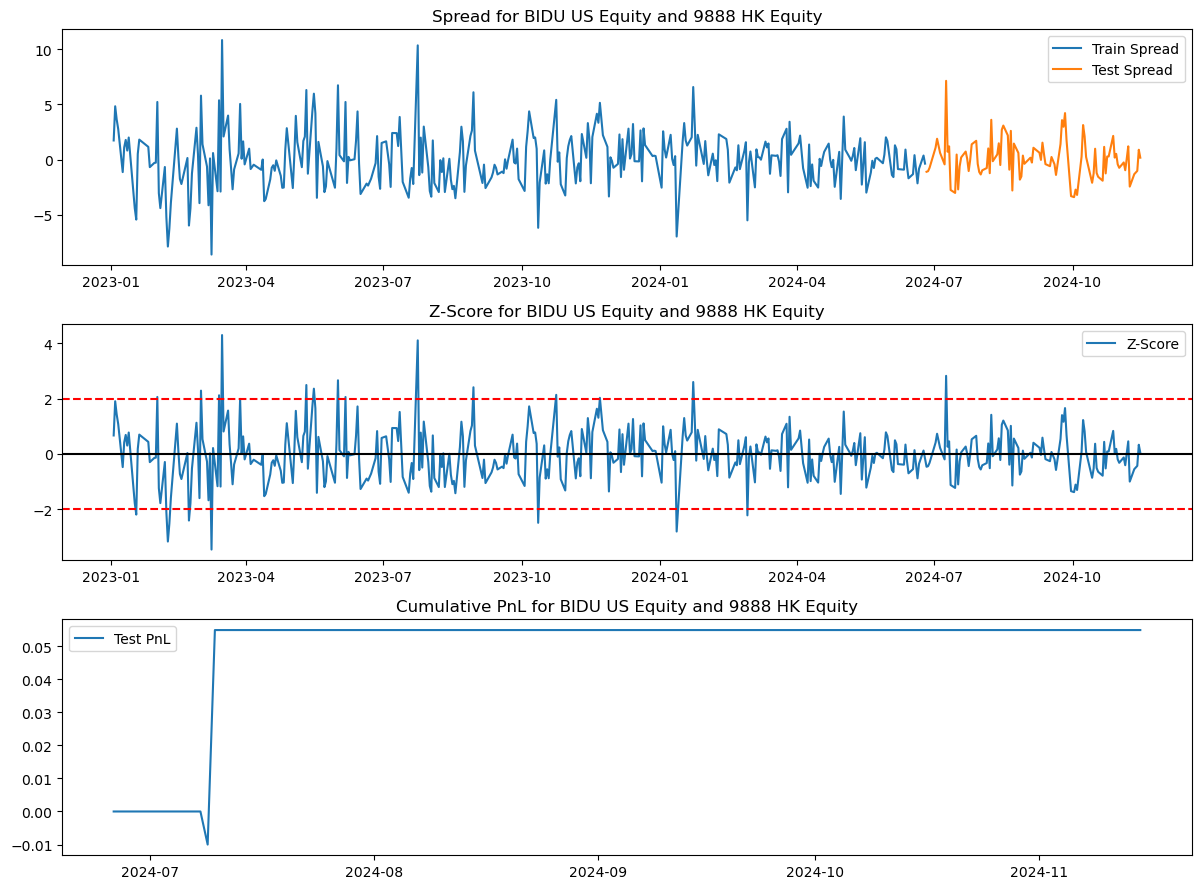

Sharpe Ratio (Train): 2.296729359968104
Sharpe Ratio (Test): 1.3593627657560379
Processing pair: NTES US Equity, 9999 HK Equity
-13.060834941761321 2.116875495614413e-23 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

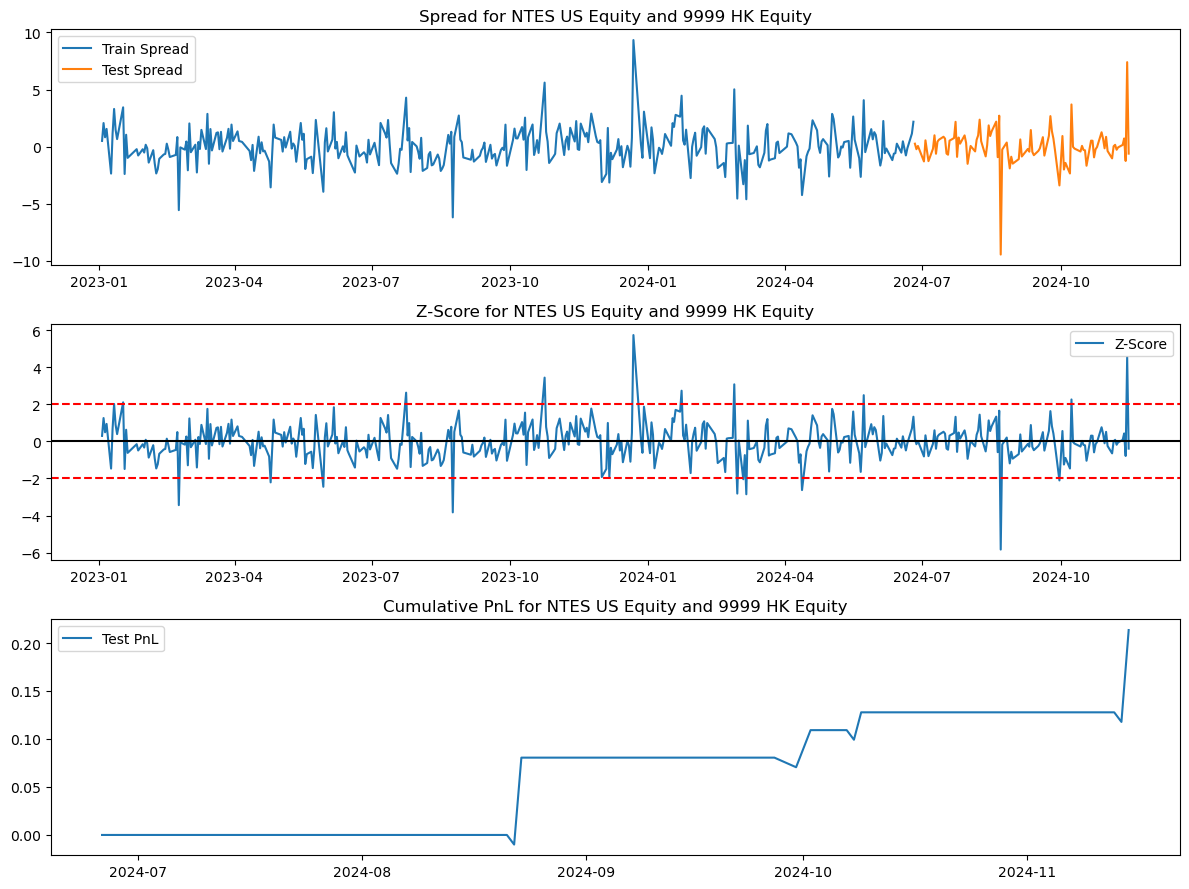

Sharpe Ratio (Train): 2.219640609913863
Sharpe Ratio (Test): 2.4708242157315845
Processing pair: XIACY US Equity, 1810 HK Equity
-12.977072852045918 3.1223236845912233e-23 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

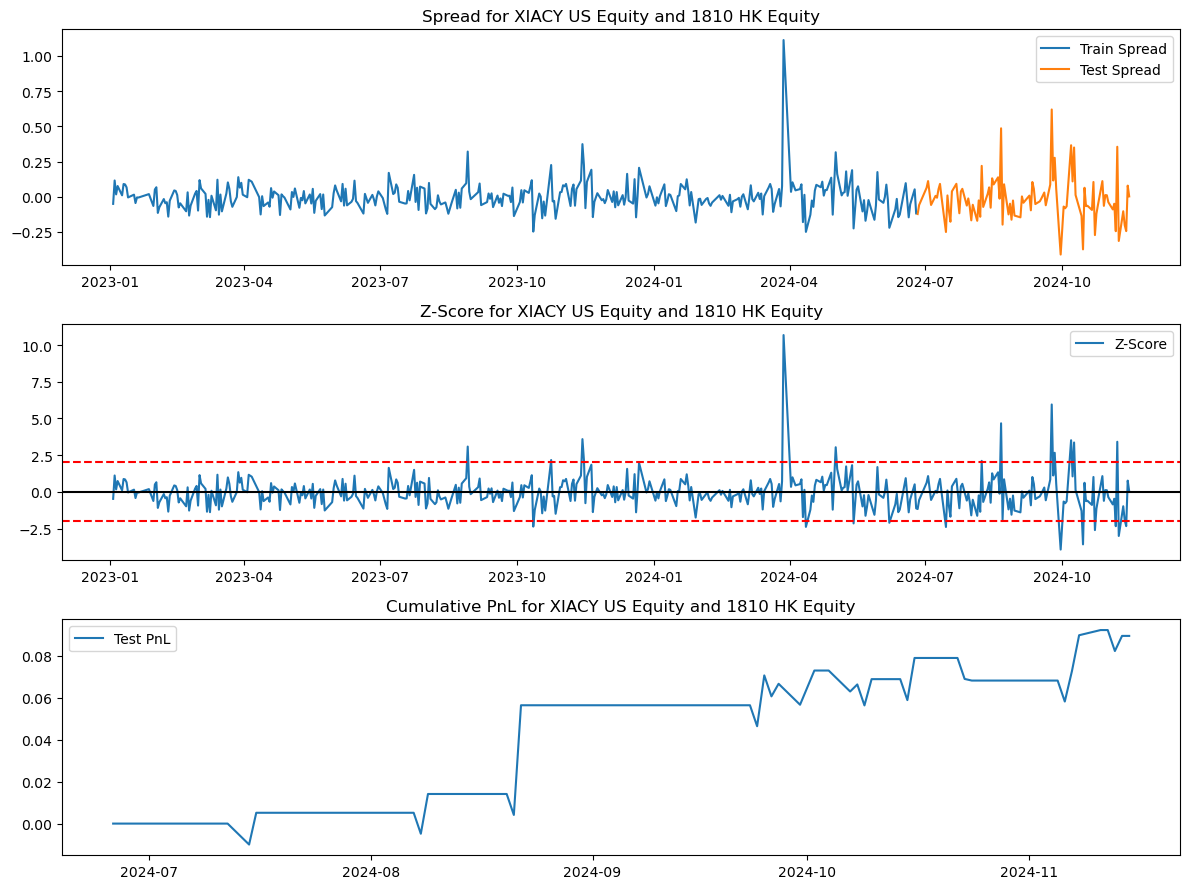

Sharpe Ratio (Train): 0.858120707687963
Sharpe Ratio (Test): 1.8036312234128187
Processing pair: MPNGY US Equity, 3690 HK Equity
-6.3140305984420495 3.311981143594774e-07 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

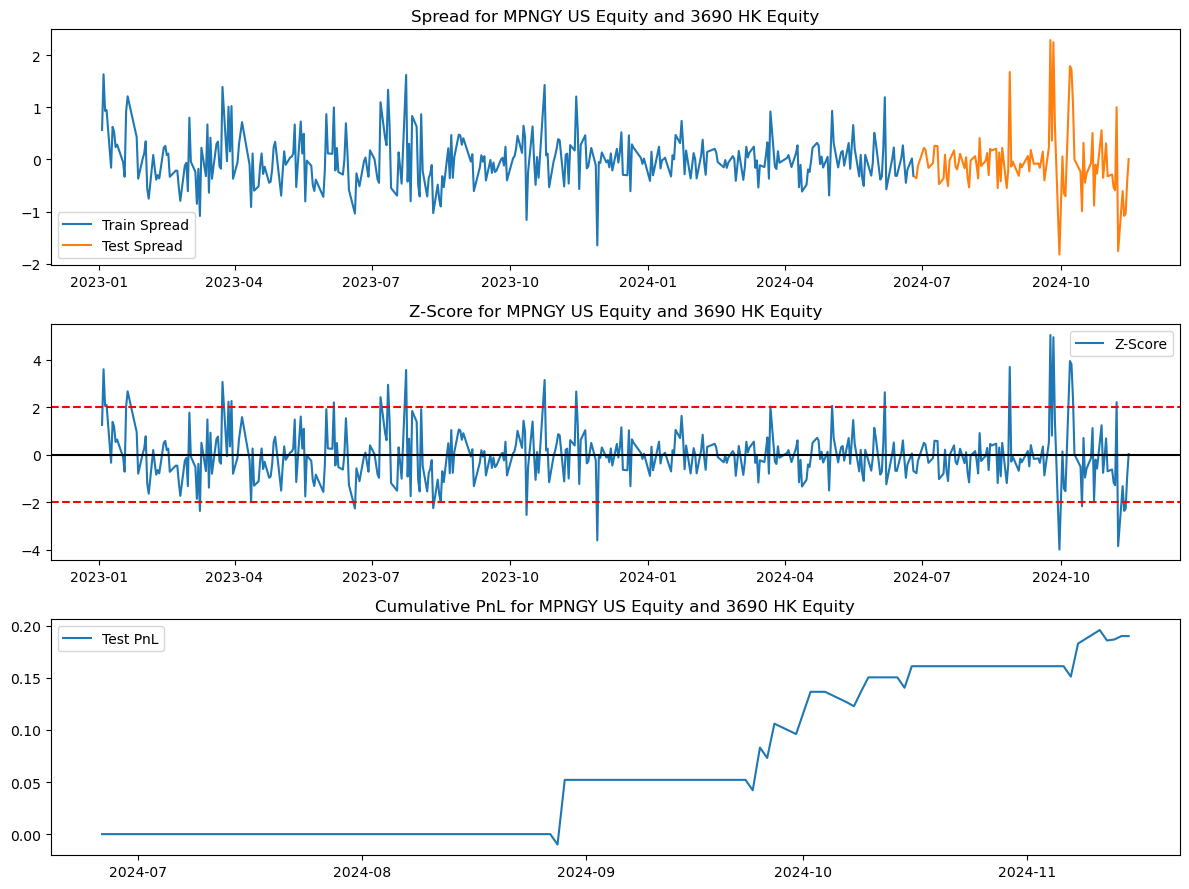

Sharpe Ratio (Train): 1.8107918402834828
Sharpe Ratio (Test): 2.976288800501462
Processing pair: LI US Equity, 2015 HK Equity
-7.09060816399867 5.214246835363275e-09 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

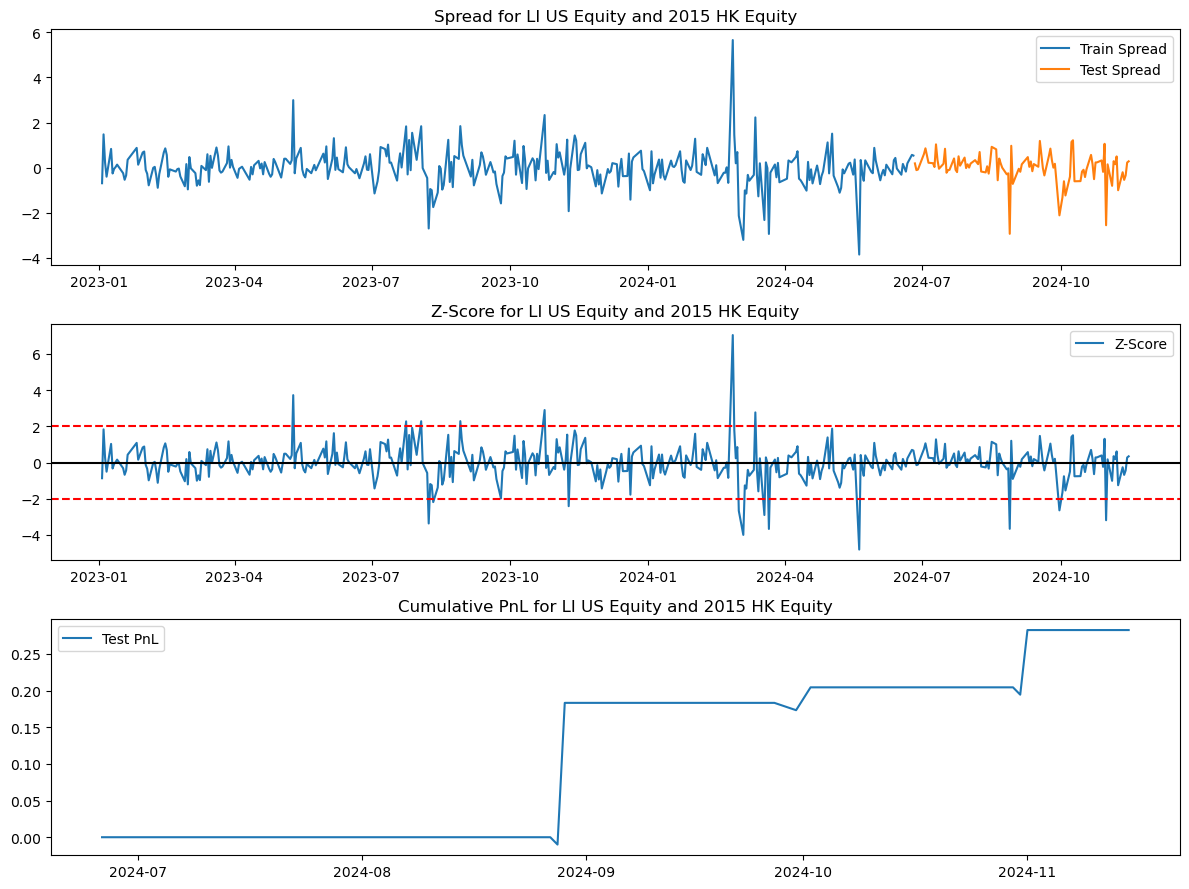

Sharpe Ratio (Train): 2.077216397618894
Sharpe Ratio (Test): 2.144949502970426
Processing pair: XPEV US Equity, 9868 HK Equity
-12.467296082852865 3.617793562164291e-22 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

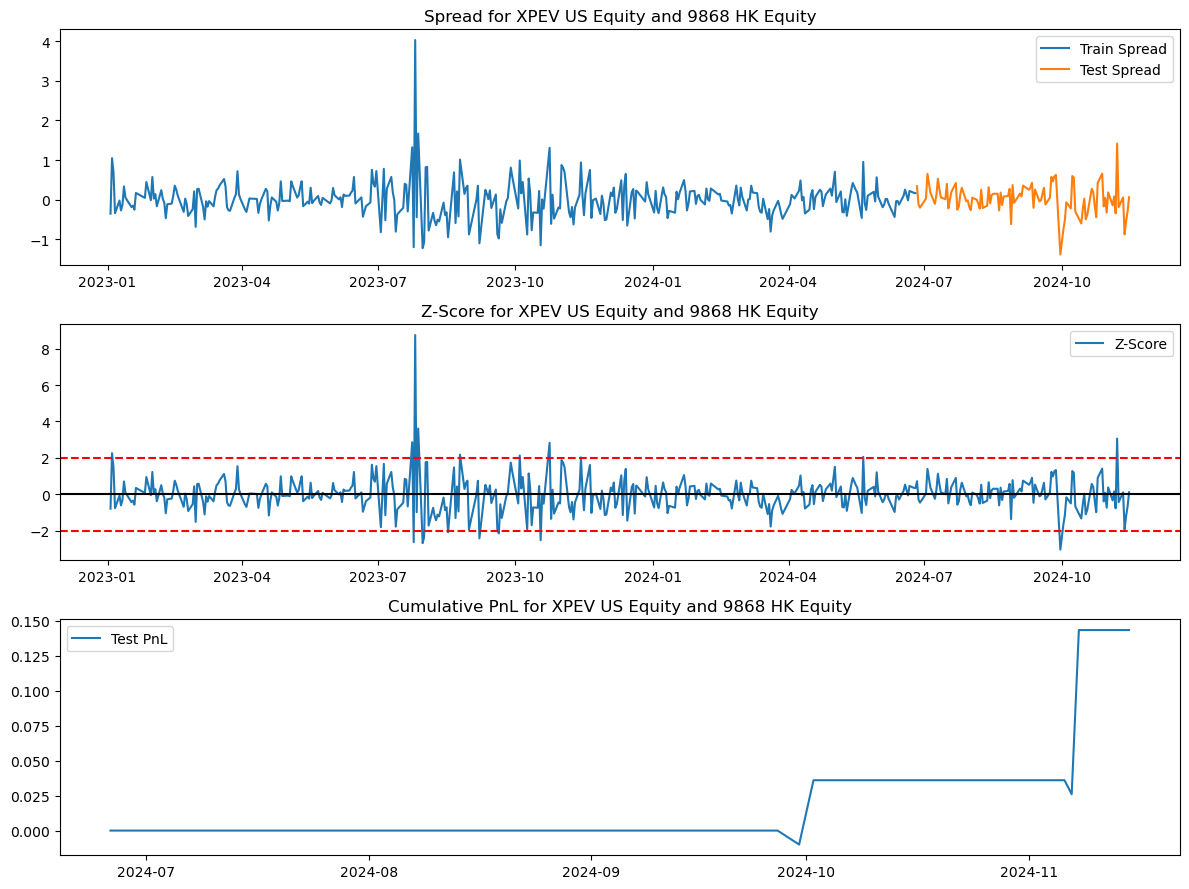

Sharpe Ratio (Train): 2.3060220513222354
Sharpe Ratio (Test): 1.8435129795519778
Processing pair: TCOM US Equity, 9961 HK Equity
-19.56744231891008 0.0 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

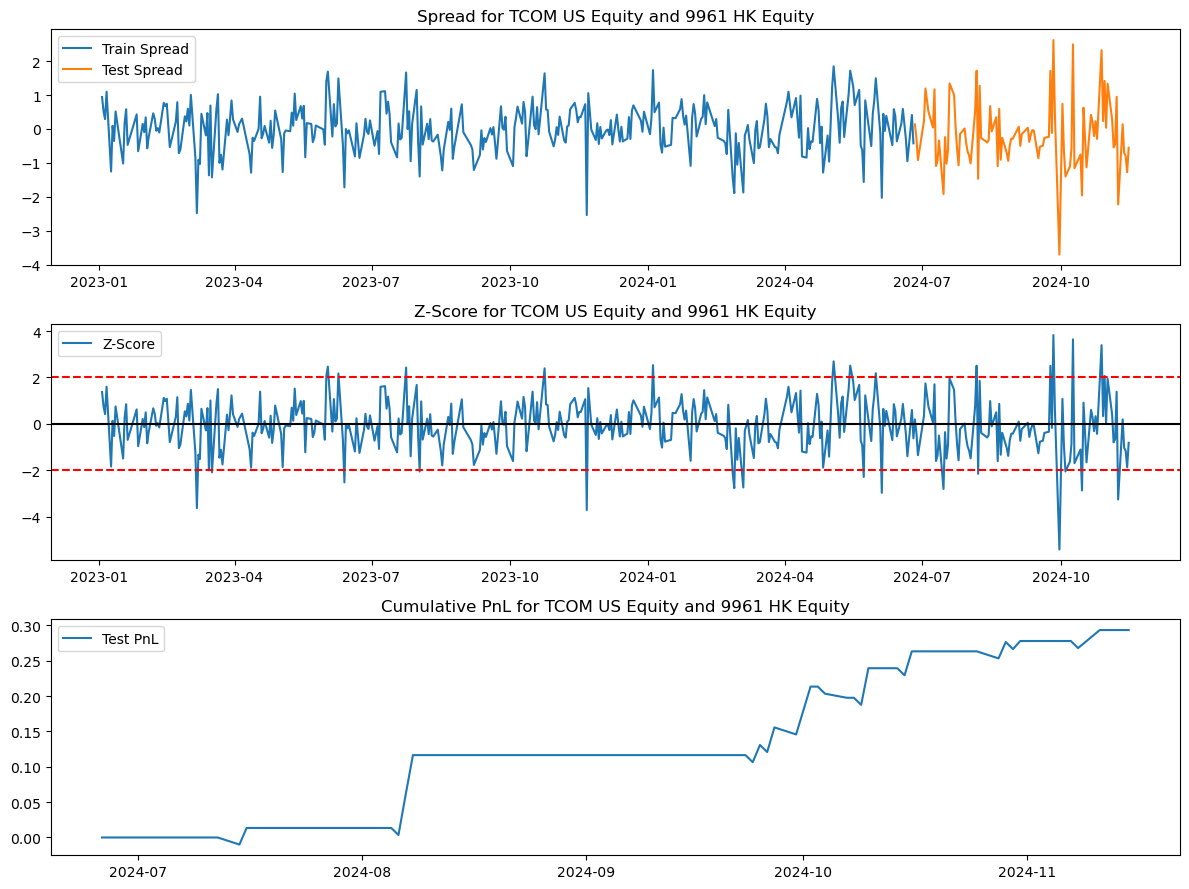

Sharpe Ratio (Train): 2.1504495511486925
Sharpe Ratio (Test): 3.474696865271015
Processing pair: YUMC US Equity, 9987 HK Equity
-10.418388751153788 2.2226244830645487e-17 [-3.92122032 -3.34989502 -3.05399452]


C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal
C:\Users\JOSE\AppData\Local\Temp\ipykernel_6636\2235890998.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

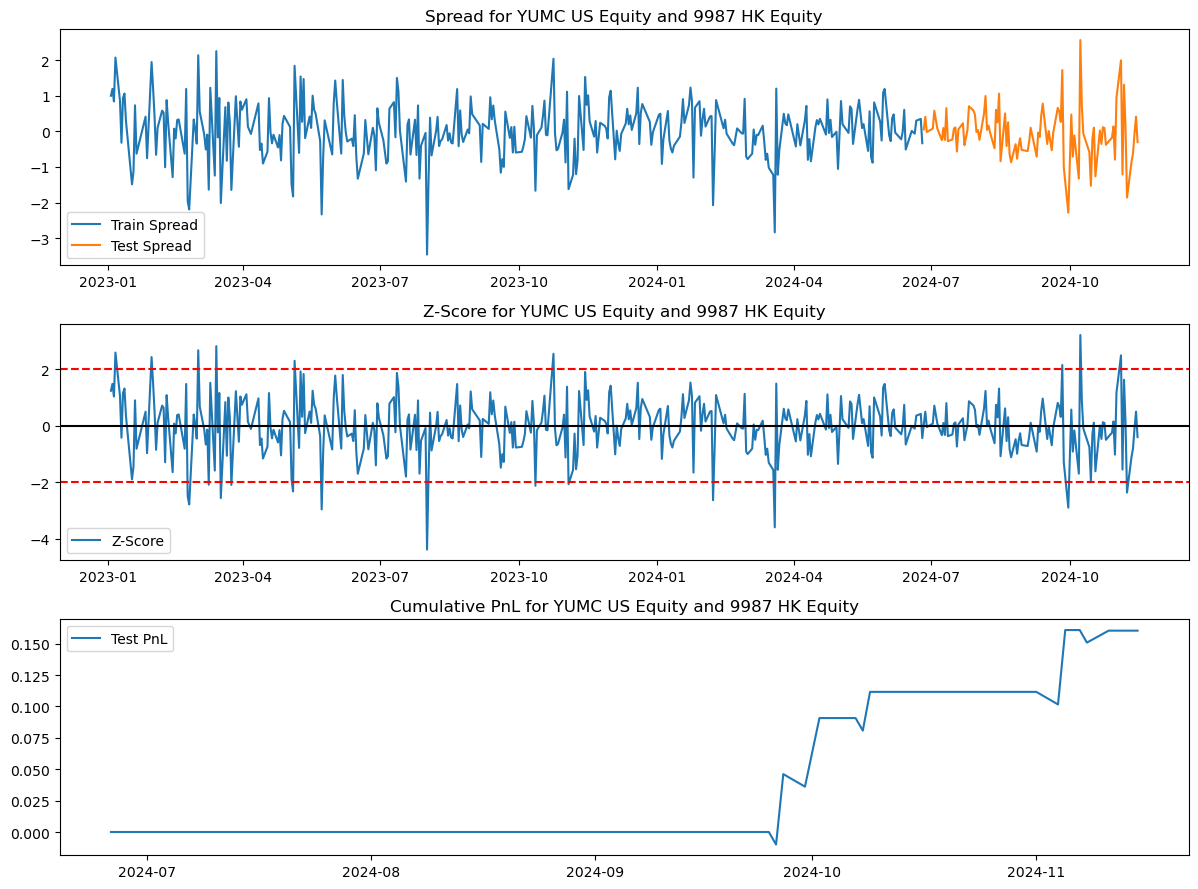

Sharpe Ratio (Train): 1.8112994747786253
Sharpe Ratio (Test): 2.4868866713742945
Combined Portfolio Sharpe Ratio: 4.78038316518955


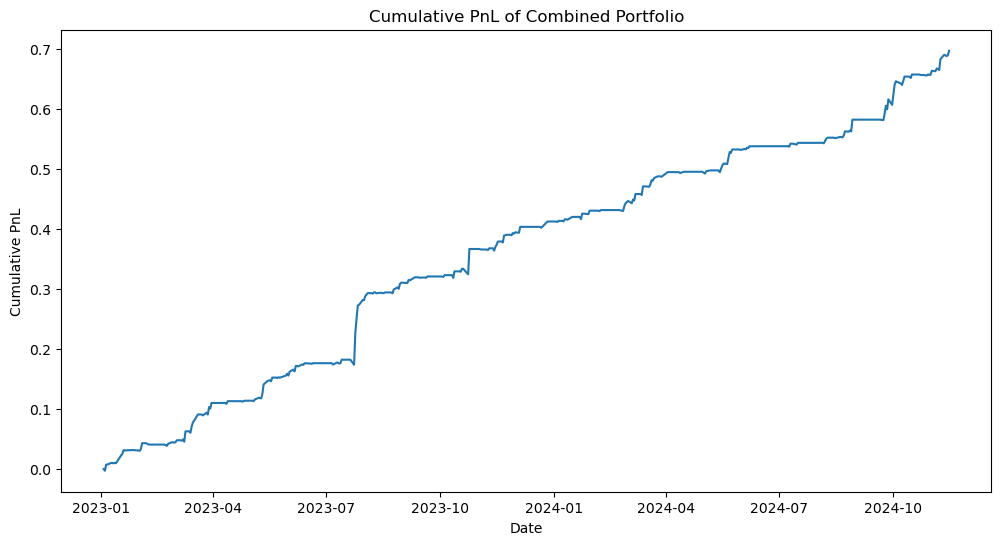

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from xbbg import blp
from datetime import datetime
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint


def run_pairs_strategy(ticker1, ticker2, start_date, end_date):
    # Clean up ticker names for column names
    def sanitize_ticker(ticker):
        return ticker.replace(' ', '_').replace('.', '').replace('&', 'and').replace('/', '_')

    ticker1_clean = sanitize_ticker(ticker1)
    ticker2_clean = sanitize_ticker(ticker2)

    # Retrieve data
    df1 = blp.bdh(ticker1, 'PX_LAST', start_date, end_date, FX='USD')
    df2 = blp.bdh(ticker2, 'PX_LAST', start_date, end_date, FX='USD')

    # Data processing
    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)
    df1.columns = ['Date', 'Adj Close']
    df2.columns = ['Date', 'Adj Close']

    df = pd.merge(df1, df2, on='Date', suffixes=('_' + ticker1_clean, '_' + ticker2_clean))
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    coint_t, pvalue, crit_value = coint(df['Adj Close_' + ticker1_clean], df['Adj Close_' + ticker2_clean])
    print( coint_t, pvalue, crit_value)

    trainset = np.arange(0, 350)
    testset = np.arange(trainset.shape[0], df.shape[0])

    # Build OLS model
    model = sm.OLS(df['Adj Close_' + ticker1_clean].iloc[trainset],
                   df['Adj Close_' + ticker2_clean].iloc[trainset])
    results = model.fit()
    hedgeRatio = results.params

    # Compute spread
    spread = df['Adj Close_' + ticker1_clean] - hedgeRatio[0] * df['Adj Close_' + ticker2_clean]
    spreadMean = np.mean(spread.iloc[trainset])
    spreadStd = np.std(spread.iloc[trainset])

    df['zscore'] = (spread - spreadMean) / spreadStd

    # Positions
    df['positions_' + ticker1_clean + '_Long'] = 0
    df['positions_' + ticker2_clean + '_Long'] = 0
    df['positions_' + ticker1_clean + '_Short'] = 0
    df['positions_' + ticker2_clean + '_Short'] = 0

    df.loc[df.zscore >= 2, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = [-1, 1]  # Short spread
    df.loc[df.zscore <= -2, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = [1, -1]  # Buy spread
    df.loc[df.zscore <= 0, ('positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short')] = 0  # Exit short spread
    df.loc[df.zscore >= 0, ('positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long')] = 0  # Exit long spread

    df.fillna(method='ffill', inplace=True)  # Carry forward existing positions unless there is an exit signal

    # Calculate positions and PnL
    positions_Long = df[['positions_' + ticker1_clean + '_Long', 'positions_' + ticker2_clean + '_Long']]
    positions_Short = df[['positions_' + ticker1_clean + '_Short', 'positions_' + ticker2_clean + '_Short']]
    positions = positions_Long.values + positions_Short.values
    positions = pd.DataFrame(positions, columns=[ticker1_clean, ticker2_clean], index=df.index)
    dailyret = df[['Adj Close_' + ticker1_clean, 'Adj Close_' + ticker2_clean]].pct_change()

    pnl = (positions.shift() * dailyret.values).sum(axis=1)
    pnl = pnl - abs(positions - positions.shift()).sum(axis=1) * 0.005  # pnl - cost of transactions at 0.005
    sharpeTrainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]])
    sharpeTestset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])

    # Plot spread, Z-score, and cumulative PnL
    plt.figure(figsize=(12, 9))
    plt.subplot(311)
    plt.title(f"Spread for {ticker1} and {ticker2}")
    plt.plot(spread.iloc[trainset], label='Train Spread')
    plt.plot(spread.iloc[testset], label='Test Spread')
    plt.legend()

    plt.subplot(312)
    plt.title(f"Z-Score for {ticker1} and {ticker2}")
    plt.plot(df.index, df['zscore'], label='Z-Score')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.axhline(0, color='black', linestyle='-')
    plt.legend()

    plt.subplot(313)
    plt.title(f"Cumulative PnL for {ticker1} and {ticker2}")
    plt.plot(np.cumsum(pnl[testset]), label='Test PnL')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save positions
    positions.to_pickle(f'positions_{ticker1_clean}_{ticker2_clean}.pkl')

    # Return outputs
    return {
        'sharpeTrainset': sharpeTrainset,
        'sharpeTestset': sharpeTestset,
        'positions': positions,
        'pnl': pnl,
        'df': df
    }

# Define your list of pairs
pairs_list = [
    # Hong Kong/China
    ('BABA US Equity', '9988 HK Equity'),  # Alibaba Group Holding Ltd.
    ('TCEHY US Equity', '700 HK Equity'),  # Tencent Holdings Ltd.
    ('MNSO US Equity', '9896 HK Equity'),  # MINISO Group Holding Ltd.
    ('JD US Equity', '9618 HK Equity'),    # JD.com Inc.
    ('PNGAY US Equity', '2318 HK Equity'), # Ping An Insurance (Group) Co. of China Ltd.
    ('BIDU US Equity', '9888 HK Equity'),  # Baidu Inc.
    ('NTES US Equity', '9999 HK Equity'),  # NetEase Inc.
    ('XIACY US Equity', '1810 HK Equity'), # Xiaomi Corp.
    ('MPNGY US Equity', '3690 HK Equity'), # Meituan Dianping
    ('LI US Equity', '2015 HK Equity'),    # Li Auto Inc.
    ('XPEV US Equity', '9868 HK Equity'),  # XPeng Inc.
    ('TCOM US Equity', '9961 HK Equity'),  # Trip.com Group Ltd.
    ('YUMC US Equity', '9987 HK Equity'),  # Yum China Holdings Inc.
]

start_date = '2023-01-01'  # Adjust the start date as needed
end_date = datetime.today().strftime('%Y-%m-%d')  # Today's date in 'YYYY-MM-DD' format

# Initialize lists to collect PnL and positions
pnl_list = []

# Loop over each pair and run the strategy
for ticker1, ticker2 in pairs_list:
    print(f"Processing pair: {ticker1}, {ticker2}")
    results = run_pairs_strategy(ticker1, ticker2, start_date, end_date)
    print(f"Sharpe Ratio (Train): {results['sharpeTrainset']}")
    print(f"Sharpe Ratio (Test): {results['sharpeTestset']}")

    # Set the name of the pnl series for identification
    ticker1_clean = ticker1.replace(' ', '_').replace('.', '').replace('&', 'and').replace('/', '_')
    ticker2_clean = ticker2.replace(' ', '_').replace('.', '').replace('&', 'and').replace('/', '_')
    results['pnl'].name = f"{ticker1_clean}_{ticker2_clean}"

    # Append pnl to the list
    pnl_list.append(results['pnl'])

# Combine PnLs into a DataFrame
pnl_df = pd.concat(pnl_list, axis=1)
pnl_df.fillna(0, inplace=True)

# Calculate total PnL by averaging PnLs (equal weights)
total_pnl = pnl_df.mean(axis=1)

# Compute cumulative PnL
cumulative_pnl = total_pnl.cumsum()

# Compute Sharpe Ratio for the combined portfolio
sharpe_total = np.sqrt(252) * total_pnl.mean() / total_pnl.std()
print(f"Combined Portfolio Sharpe Ratio: {sharpe_total}")

# Plot cumulative PnL of the combined portfolio
plt.figure(figsize=(12, 6))
plt.title("Cumulative PnL of Combined Portfolio")
plt.plot(cumulative_pnl)
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.show()
